# Import Necessary Libraries

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from arch.univariate import ConstantMean, GARCH, StudentsT
from pyextremes import EVA
from pyextremes import plot_mean_residual_life, plot_parameter_stability
from scipy.stats import kstest, anderson, anderson, genpareto, t
import warnings
warnings.filterwarnings('ignore')

# Download SBIN, INFY data using yfinance

In [4]:
tickers = ["SBIN.NS", "INFY.NS"]
data = yf.download(tickers, group_by="ticker", period="max")

# Select only 'Close'
close = data.xs('Close', axis=1, level=1).dropna()

# Compute daily log returns in %
returns = np.log(close/close.shift(1)).dropna() * 100

print("\nLog Returns of SBIN, INFY over time:\n")
display(returns.head(3))

[*********************100%***********************]  2 of 2 completed


Log Returns of SBIN, INFY over time:



Ticker,INFY.NS,SBIN.NS
Date,,
1996-01-02,-0.405307,-3.234742
1996-01-03,0.674679,-2.702507
1996-01-04,-0.662407,-0.346357


# Plot Log Returns

In [6]:
def plot_returns(log_returns, stock_symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(log_returns.index, log_returns, label=f'{stock_symbol}_Log_Returns')
    plt.title('Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

### Plot SBIN Log Returns

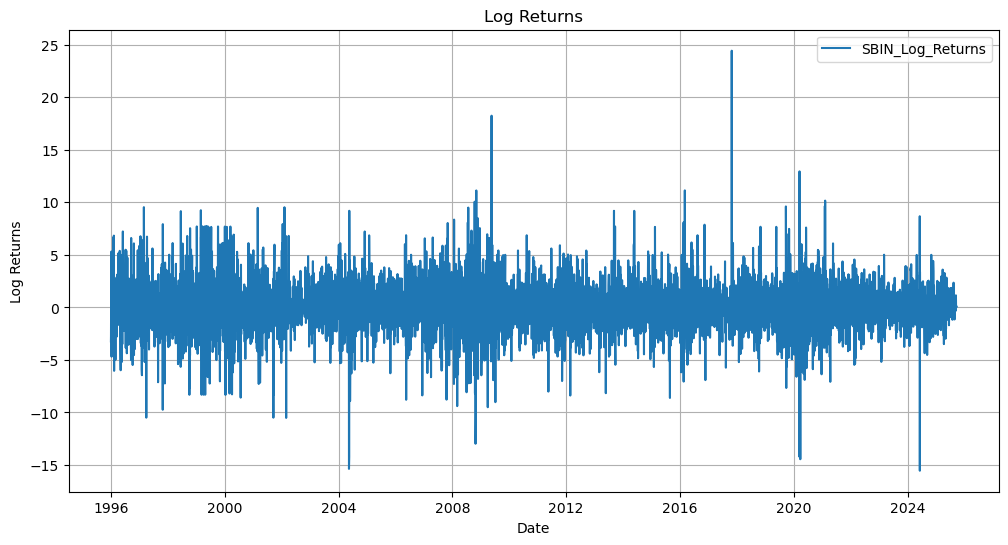

In [8]:
# Plot Log Returns of SBIN.NS
plot_returns(returns["SBIN.NS"], 'SBIN')

### Plot INFY Log Returns

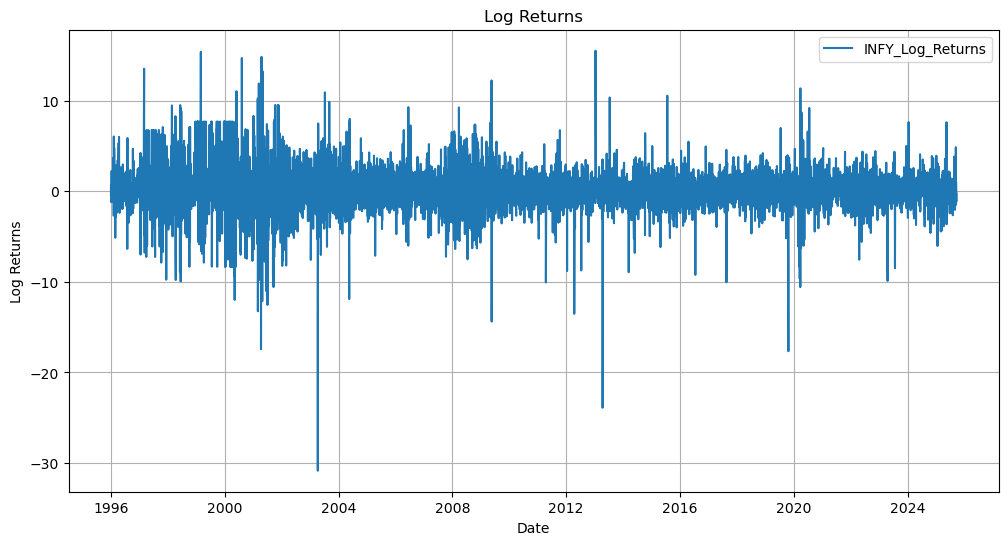

In [10]:
# Plot Log Returns of INFY.NS
plot_returns(returns["INFY.NS"], 'INFY')

# Find Best Arima model on Log Returns

In [12]:
def arima_analysis(data, train_percentage):
    # Perform train-test split
    train_size = int(len(data) * train_percentage)
    train, test = data[0:train_size], data[train_size:]
    print('Train data shape:', train.shape)
    print('Test data shape:', test.shape)
    
    # Find best ARIMA model
    print("Searching for the best ARIMA model...")
    best_model = pm.auto_arima(train,
                              start_p=1,
                              start_q=1,
                              max_p=7,
                              max_q=7,
                              start_P=0,
                              m=3,
                              test='adf',
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              D=1,
                              suppress_warnings=True,
                              stepwise=True)
    
    print("\n==== Best Model Summary ====")
    print(best_model.summary())
    
    # Forecast on test
    forecast, conf_int = best_model.predict(n_periods=len(test), return_conf_int=True)
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f"RMSE: {rmse:.4f}")
    
    # Compute MAPE
    mape = mean_absolute_percentage_error(test, forecast) * 100
    print(f"MAPE: {mape:.2f}%")
    
    # Get AIC and BIC
    aic = best_model.aic()
    bic = best_model.bic()
    print(f"AIC: {aic:.4f}")
    print(f"BIC: {bic:.4f}")
    
    # Print Confidence interval
    conf_int_df = pd.DataFrame(conf_int, index=test.index, columns=['Lower', 'Upper'])
    print("\nConfidence Interval (first 2 rows):")
    print(conf_int_df.head(2))
    
    return train, test, best_model

### Best Arima Model For SBIN

In [14]:
train_sbin, test_sbin, arima_sbin = arima_analysis(returns["SBIN.NS"], 0.95)

Train data shape: (7086,)
Test data shape: (373,)
Searching for the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=32273.873, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32296.725, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=32274.126, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32273.303, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=32273.839, Time=0.49 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=32275.877, Time=0.60 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=32271.535, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=32294.496, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=32272.021, Time=1.79 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=32271.957, Time=1.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32272.369, Time=0.41 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=32274.030, Time=1.63 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 8.

### Best Arima Model For INFY 

In [16]:
train_infy, test_infy, arima_infy = arima_analysis(returns["INFY.NS"], 0.95)

Train data shape: (7086,)
Test data shape: (373,)
Searching for the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=32548.552, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32577.844, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=32548.380, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32547.355, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=32548.218, Time=0.52 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=2.43 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=32535.496, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=32564.119, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=32536.455, Time=1.64 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=32535.952, Time=1.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=32536.585, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=32531.822, Time=3.89 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=32532.479, Time=9.01 sec
 ARI

# Fit the GJR-GARCH-StudentT model after fitted the Best ARIMA Model for the corrosponding data(stock)

In [18]:
def gjr_garch_model_analysis(arima_model):
    # Get residuals from ARIMA model
    residuals = arima_model.resid()
    
    am = ConstantMean(residuals)
    am.volatility = GARCH(1, 1, 1)
    am.distribution = StudentsT()
    result = am.fit(disp="off")
    
    print(result.summary())
    
    # Get AIC and BIC
    aic = result.aic
    bic = result.bic
    print(f"AIC: {aic:.4f}")
    print(f"BIC: {bic:.4f}")
    
    return am

### Fit GJR-GARCH-StudentT model on SBIN

In [20]:
gjr_sbin = gjr_garch_model_analysis(arima_sbin)

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -15383.9
Distribution:      Standardized Student's t   AIC:                           30779.9
Method:                  Maximum Likelihood   BIC:                           30821.1
                                              No. Observations:                 7086
Date:                      Tue, Sep 16 2025   Df Residuals:                     7085
Time:                              10:47:27   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

In [21]:
def residual_tests(std_resid):
    # Ljung–Box on residuals
    lb_resid = sm.stats.acorr_ljungbox(std_resid, lags=[10,20], return_df=True)
    print("Ljung–Box on residuals:")
    print(lb_resid)
    
    # Ljung–Box on squared residuals (volatility clustering)
    lb_resid2 = sm.stats.acorr_ljungbox(std_resid**2, lags=[10,20], return_df=True)
    print("\nLjung–Box on squared residuals:")
    print(lb_resid2)
    
    # ARCH LM test
    lm_stat, lm_pvalue, _, _ = het_arch(std_resid, nlags=21)
    print('\nARCH LM p-value:', lm_pvalue)

In [22]:
std_resid = gjr_sbin.fit(disp="off").std_resid.dropna()
residual_tests(std_resid)

Ljung–Box on residuals:
      lb_stat  lb_pvalue
10  29.213217   0.001151
20  43.201268   0.001923

Ljung–Box on squared residuals:
      lb_stat  lb_pvalue
10   7.562244   0.671511
20  14.046226   0.828144

ARCH LM p-value: 0.8366305567854514


In [23]:
def plot_residual_diagnostics(model, lags=30):
    residuals = model.resid / model.conditional_volatility
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    sns.lineplot(x=range(len(residuals)), y=residuals, ax=ax[0, 0])
    ax[0, 0].set_title("Standardized Residuals")

    sns.histplot(residuals, kde=True, ax=ax[0, 1])
    ax[0, 1].set_title("Residuals Distribution")

    stats.probplot(residuals, dist="norm", plot=ax[1, 0])
    ax[1, 0].set_title("Q-Q Plot")

    plot_acf(residuals, lags=lags, ax=ax[1, 1])
    ax[1, 1].set_title("ACF of Residuals")

    plt.tight_layout()
    plt.show()

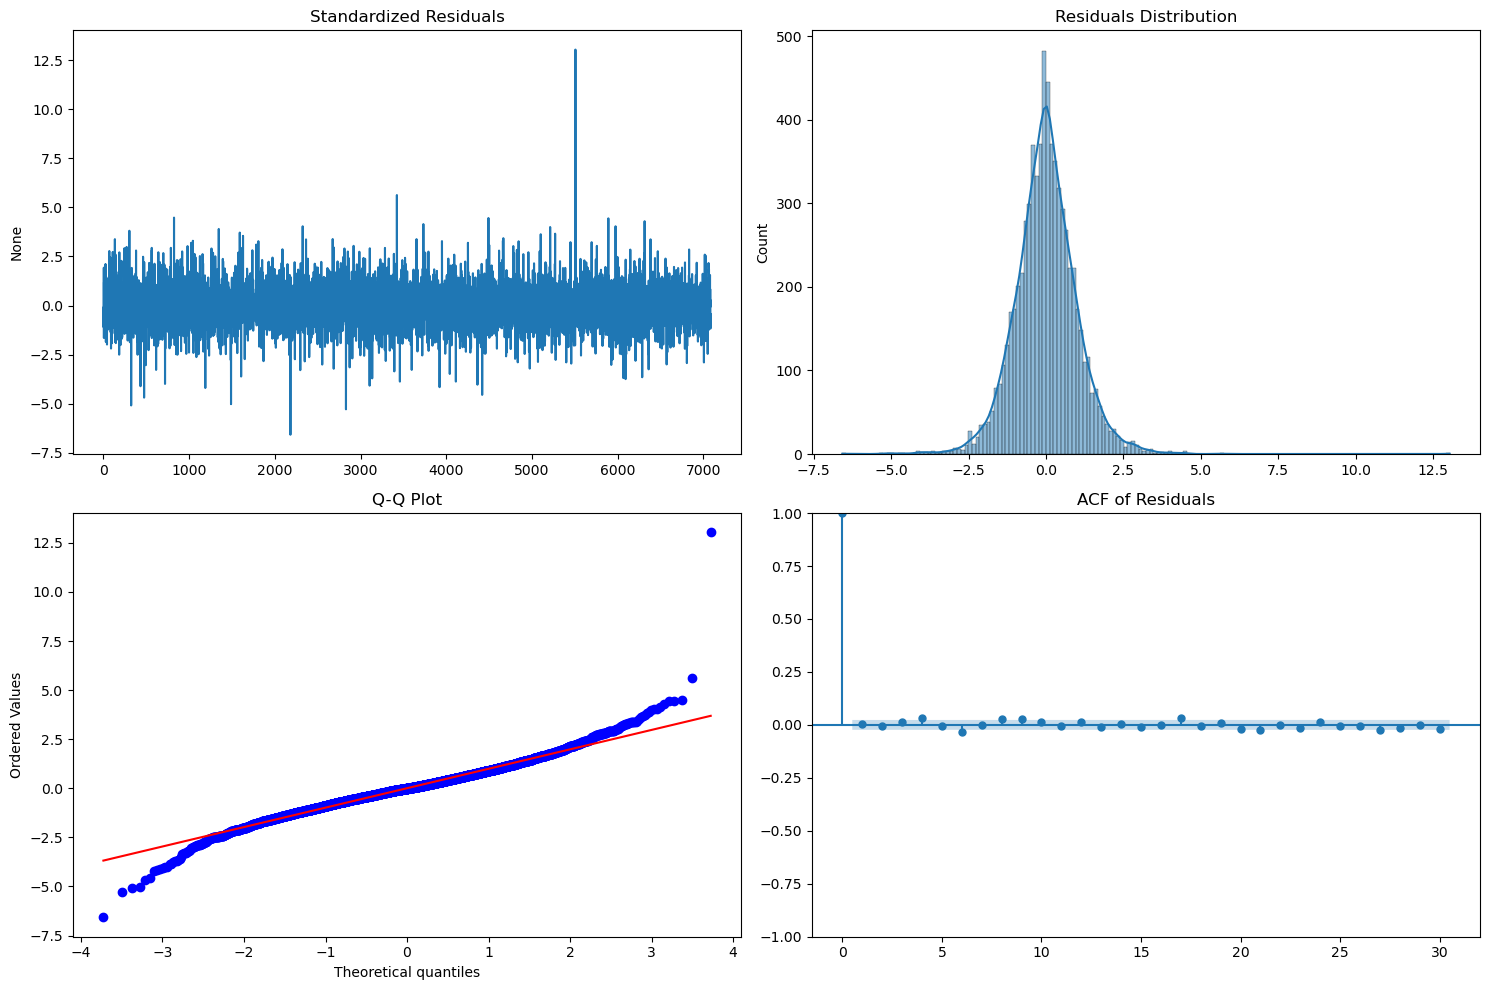

In [24]:
# Ploting residual diagnostics for SBIN
plot_residual_diagnostics(gjr_sbin.fit(disp="off"))

### Fit GJR-GARCH-StudentT model on INFY

In [26]:
gjr_infy = gjr_garch_model_analysis(arima_infy)

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -14747.6
Distribution:      Standardized Student's t   AIC:                           29507.3
Method:                  Maximum Likelihood   BIC:                           29548.5
                                              No. Observations:                 7086
Date:                      Tue, Sep 16 2025   Df Residuals:                     7085
Time:                              10:47:29   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [27]:
std_resid = gjr_infy.fit(disp="off").std_resid.dropna()
residual_tests(std_resid)

Ljung–Box on residuals:
      lb_stat  lb_pvalue
10   7.689331   0.659153
20  20.502552   0.426913

Ljung–Box on squared residuals:
      lb_stat  lb_pvalue
10   7.577935   0.669987
20  11.701813   0.925957

ARCH LM p-value: 0.9102551081029809


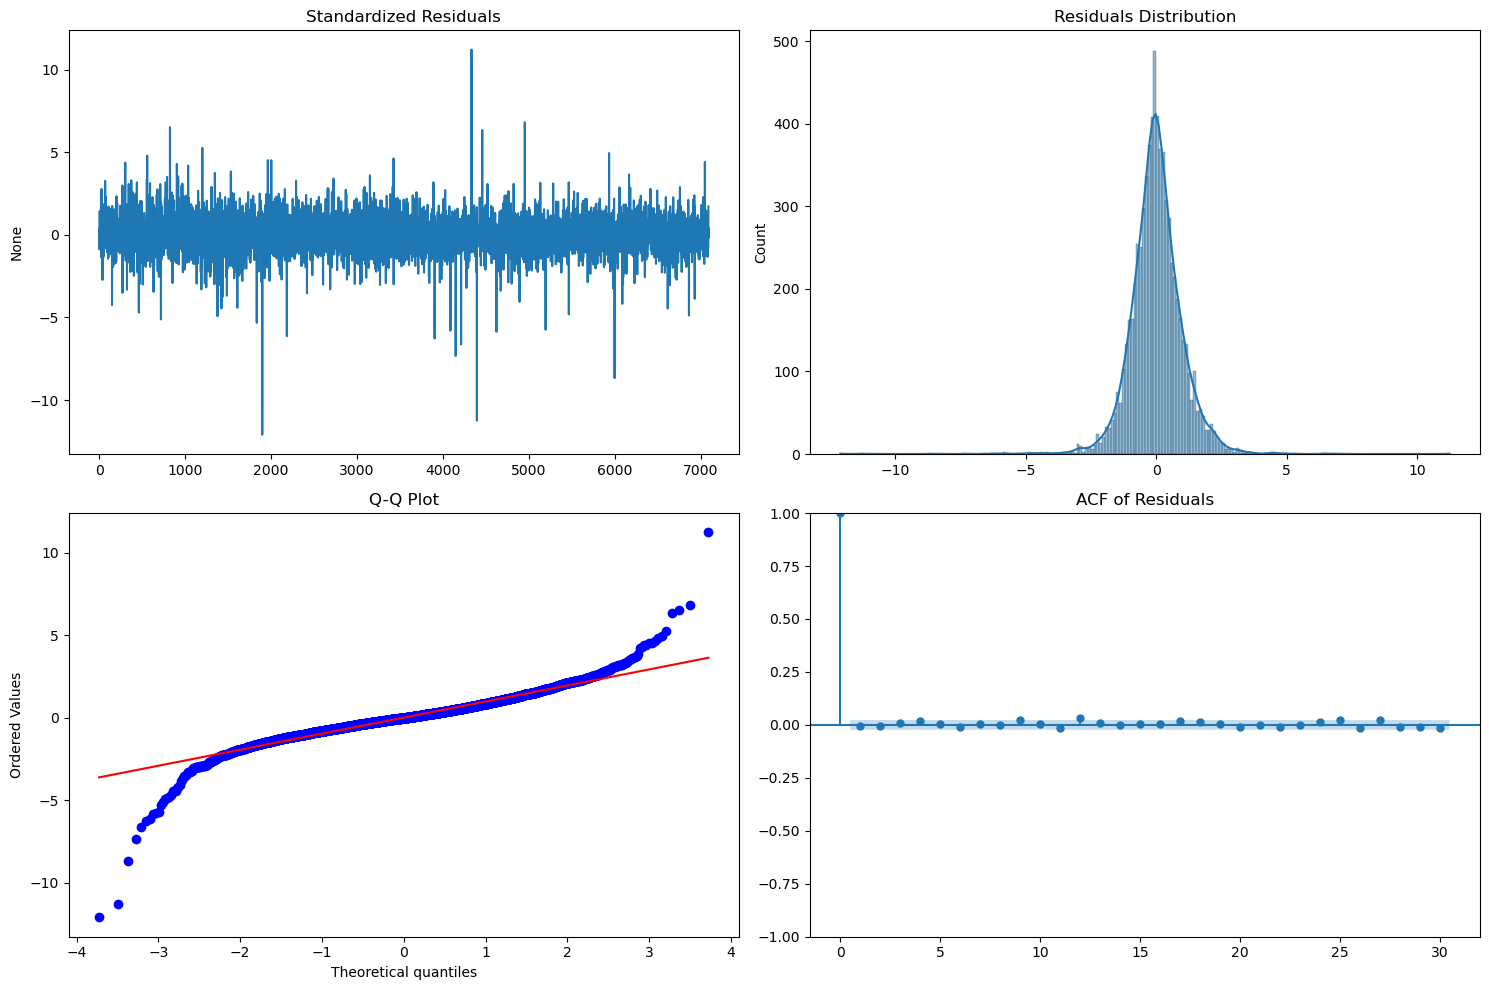

In [28]:
# Ploting residual diagnostics for INFY
plot_residual_diagnostics(gjr_infy.fit(disp="off"))

# Rolling Forcasting

In [30]:
def gjr_rolling_forecast(arima_model, test):
    # Use ARIMA model residuals instead of original training data
    residuals = arima_model.resid()
    history = residuals.tolist()
    predictions = []

    for t in range(len(test)):
        # Fit GJR-GARCH model on residuals history
        model = arch_model(history, vol='Garch', p=1, o=1, q=1, dist='studentst', mean='Constant')
        fit = model.fit(disp='off')
        pred = fit.forecast(horizon=1)
        predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
        
        # Generate ARIMA forecast for current test observation
        arima_forecast = arima_model.predict(n_periods=1)
        
        # Calculate residual: actual - forecast
        # Use .values to get the actual numeric values
        new_residual = test.iloc[t] - arima_forecast.values[0]
        history.append(new_residual)

    return pd.Series(predictions, index=test.index)

In [31]:
def gjr_actual_rolling_std(train, test, window=40):
  extended_test = pd.concat([train.iloc[-window:], test])
  rolling_std = extended_test.rolling(window).std()
  return rolling_std[-len(test):]

In [32]:
def plot_volatility(test_index, actual, predicted):
  plt.figure(figsize=(14, 7))
  plt.plot(test_index, actual, label='Actual Rolling Std Dev')
  plt.plot(test_index, predicted, label='Predicted Volatility', color='red')
  plt.title(f'Actual Rolling Std Dev vs Predicted Volatility')
  plt.xlabel('Date')
  plt.ylabel('Volatility / Std Dev')
  plt.legend()
  plt.show()

### Roling Forcasting on SBIN

RMSE: 0.5047


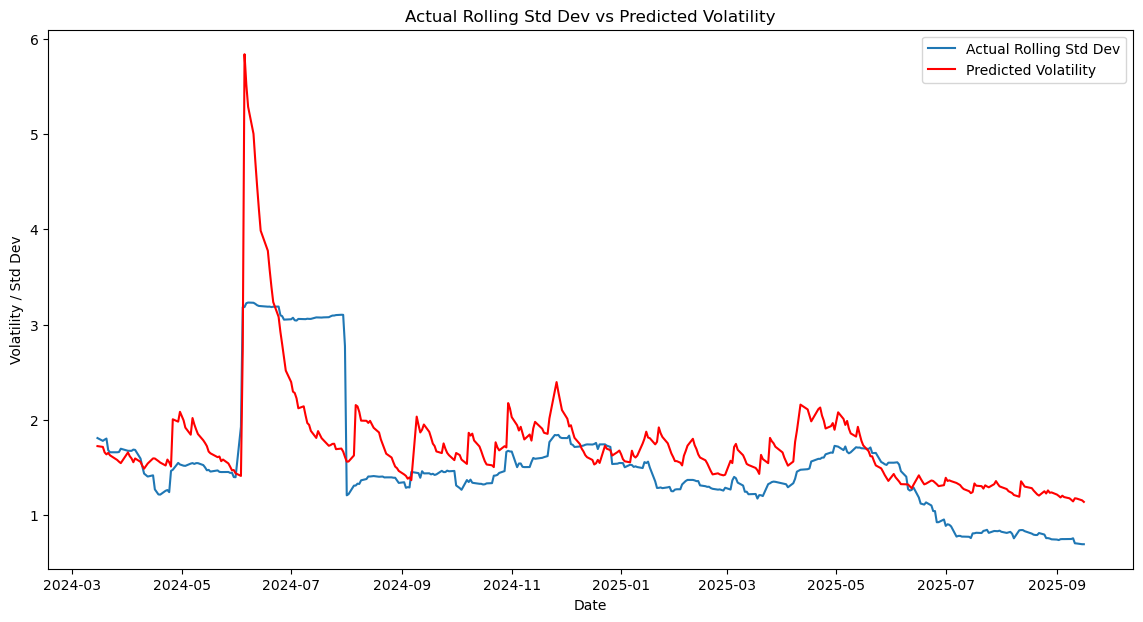

In [34]:
# Rolling forecast for SBIN
rolling_sbin = gjr_rolling_forecast(arima_sbin, test_sbin)
# Actual rolling std dev
actual_sbin = gjr_actual_rolling_std(train_sbin, test_sbin)
# RMSE between actual and predicted volatility
rmse = np.sqrt(mean_squared_error(actual_sbin, rolling_sbin))
print(f"RMSE: {rmse:.4f}")
# Plot
plot_volatility(test_sbin.index, actual_sbin, rolling_sbin)

### Rolling Forcasting on INFY

RMSE: 0.4664


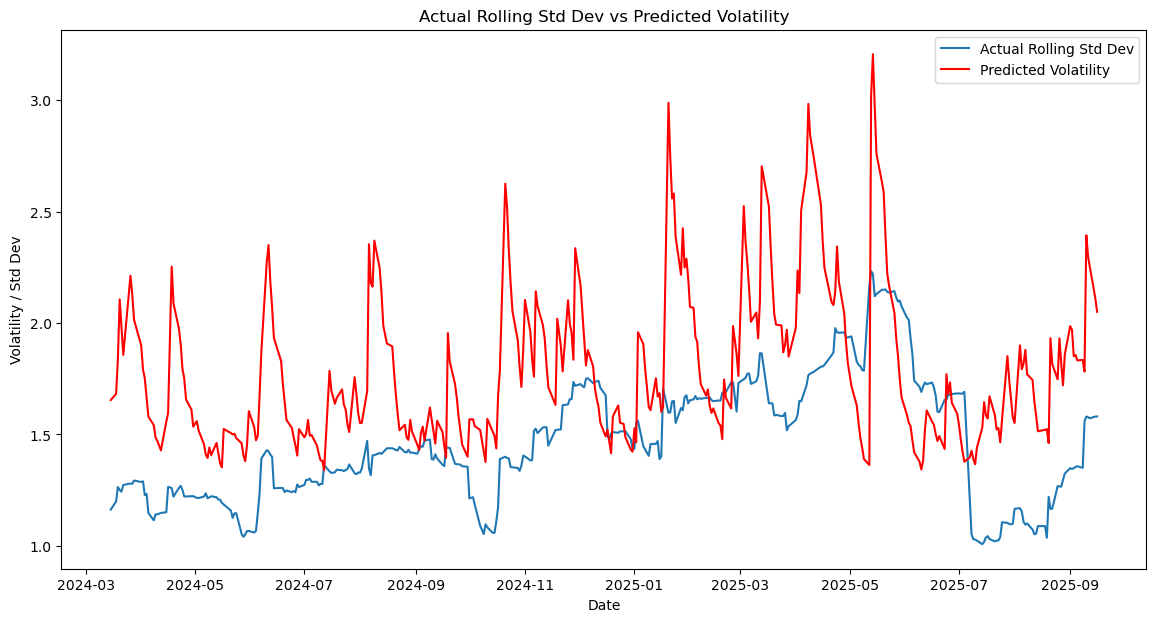

In [36]:
# Rolling forecast for INFY
rolling_infy = gjr_rolling_forecast(arima_infy, test_infy)
# Actual rolling std dev
actual_infy = gjr_actual_rolling_std(train_infy, test_infy)
# RMSE between actual and predicted volatility
rmse = np.sqrt(mean_squared_error(actual_infy, rolling_infy))
print(f"RMSE: {rmse:.4f}")
# Plot
plot_volatility(test_infy.index, actual_infy, rolling_infy)

# EVT (POT) thresholding and GPD fit on SBIN.NS

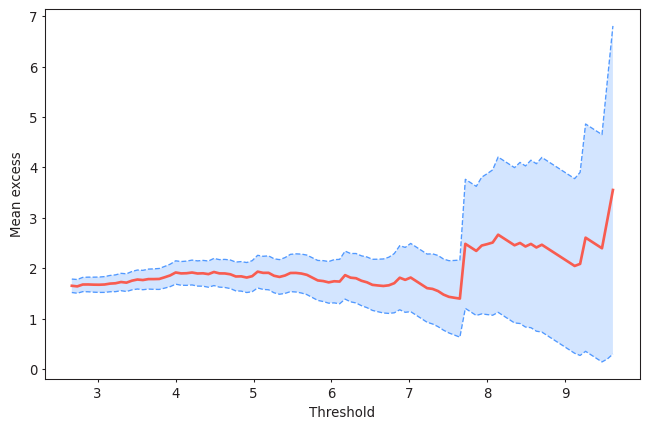

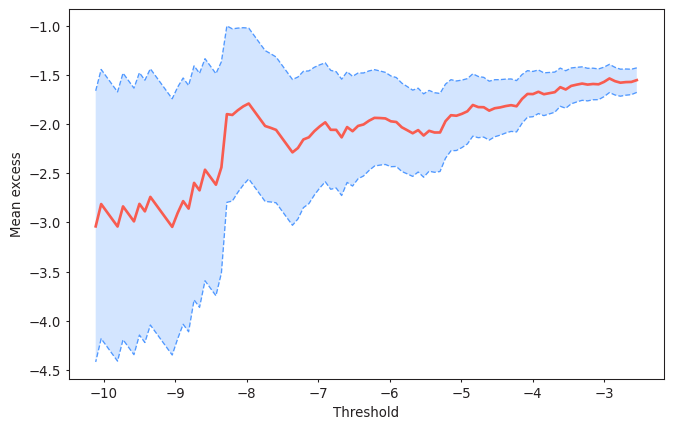

In [38]:
r = returns['SBIN.NS']
model = EVA(data=r)

# Plot Mean Residual Life
plot_mean_residual_life(r, alpha=0.95, extremes_type='high')
plot_mean_residual_life(r, alpha=0.95, extremes_type='low')
plt.show()

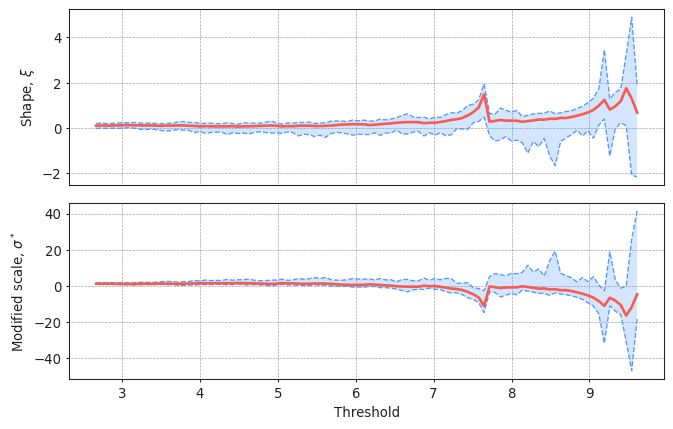

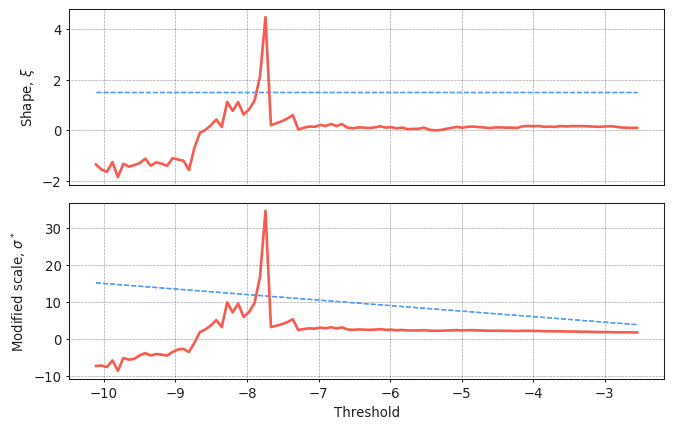

In [39]:
# Plot parameter stability
plot_parameter_stability(r, alpha=0.95, extremes_type="high")
plot_parameter_stability(r, alpha=0.95, extremes_type="low")
plt.show()

## Best Threshold Selection 

In [41]:
# Find Best threshold (quantile) so that p value > 0.05
def select_threshold(r, q_range, min_exceedances=100, tail="upper"):
    results = []
    r = np.asarray(r)

    for q in q_range:
        thr = np.quantile(r, q)

        if tail == "upper":
            exceedances = r[r > thr] - thr
        elif tail == "lower":
            exceedances = thr - r[r < thr]
        else:
            raise ValueError("tail must be 'upper' or 'lower'")

        n_exc = len(exceedances)
        if n_exc < min_exceedances:
            continue

        shape, loc, scale = genpareto.fit(exceedances, floc=0)

        ks_stat, ks_p = kstest(exceedances, "genpareto", args=(shape, 0, scale))

        u = genpareto.cdf(exceedances, c=shape, loc=0, scale=scale)
        u = np.clip(u, 1e-12, 1 - 1e-12)
        exp_data = -np.log(u)
        ad_res = anderson(exp_data, dist="expon")
        ad_stat = ad_res.statistic

        score = ks_p - ad_stat / 10.0

        results.append({
            "quantile": q,
            "threshold": thr,
            "n_exc": n_exc,
            "shape": shape,
            "scale": scale,
            "ks_stat": ks_stat,
            "ks_p": ks_p,
            "ad_stat": ad_stat,
            "score": score
        })

    results = sorted(results, key=lambda x: -x["score"])
    return results

### Upper Threshold , corrosponding KS-P value, AD Statistics

In [87]:
upper_results = select_threshold(r, q_range=np.arange(0.92, 0.981, 0.005), tail="upper")
upper_best = upper_results[9]
print("Upper Best threshold selection:")
print(f"Quantile: {upper_best['quantile']:.3f}, Threshold: {upper_best['threshold']:.4f}")
print(f"Exceedances: {upper_best['n_exc']}, Shape: {upper_best['shape']:.4f}, Scale: {upper_best['scale']:.4f}")
print(f"KS p={upper_best['ks_p']:.4f}, AD stat={upper_best['ad_stat']:.4f}, Score={upper_best['score']:.4f}")
print()


Upper Best threshold selection:
Quantile: 0.950, Threshold: 3.7167
Exceedances: 373, Shape: 0.0756, Scale: 1.6505
KS p=0.4344, AD stat=1.1088, Score=0.3235



### Lower Threshold , corrosponding KS-P value, AD Statistics

In [89]:
lower_results = select_threshold(r, q_range=np.arange(0.02, 0.081, 0.005), tail="lower")
lower_best = lower_results[6]
print("Best lower threshold selection:")
print(f"Quantile: {lower_best['quantile']:.3f}, Threshold: {lower_best['threshold']:.4f}")
print(f"Exceedances: {lower_best['n_exc']}, Shape: {lower_best['shape']:.4f}, Scale: {lower_best['scale']:.4f}")
print(f"KS p={lower_best['ks_p']:.4f}, AD stat={lower_best['ad_stat']:.4f}, Score={lower_best['score']:.4f}")


Best lower threshold selection:
Quantile: 0.045, Threshold: -3.6935
Exceedances: 336, Shape: 0.1344, Scale: 1.4497
KS p=0.9168, AD stat=0.3173, Score=0.8851


## Smooth CDF, t-Body and GPD tail with Logistics splice

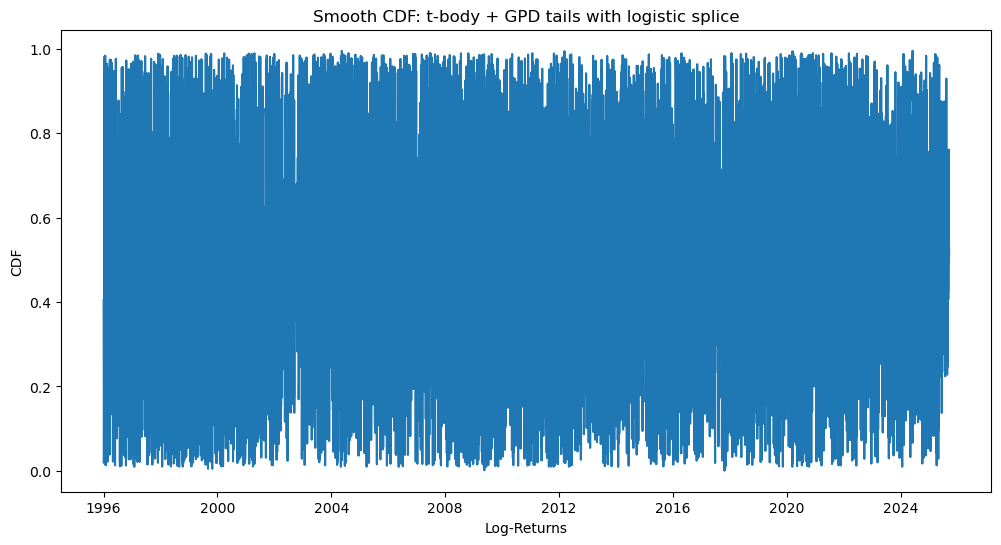

In [92]:
upper_threshold = upper_best['threshold']
shape_upper = upper_best['shape']
scale_upper = upper_best['scale']
lower_threshold = lower_best['threshold']
shape_lower = lower_best['shape']
scale_lower = lower_best['scale']

# Small transition width
k = 0.001 * (upper_threshold - lower_threshold)

# Fit body (t-distribution)
df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

# Logistic splice
def logistic_splice(x, x0, k):
    return 1 / (1 + np.exp(-(x-x0)/k))

# Smooth CDF
def smooth_cdf(x):
    F = np.zeros_like(x, dtype=float)

    # Lower tail
    mask_lower = x <= lower_threshold
    F[mask_lower] = (1 - logistic_splice(x[mask_lower], lower_threshold, k)) * genpareto.cdf(lower_threshold - x[mask_lower], shape_lower, 0, scale_lower) \
                + logistic_splice(x[mask_lower], lower_threshold, k) * t.cdf(x[mask_lower], df_body, loc_body, scale_body)

    # Body
    mask_body = (x > lower_threshold) & (x < upper_threshold)
    F[mask_body] = t.cdf(x[mask_body], df_body, loc_body, scale_body)

    # Upper tail
    mask_upper = x >= upper_threshold
    F[mask_upper] = (1 - logistic_splice(x[mask_upper], upper_threshold, k)) * t.cdf(x[mask_upper], df_body, loc_body, scale_body) \
                + logistic_splice(x[mask_upper], upper_threshold, k) * (1 - genpareto.cdf(x[mask_upper] - upper_threshold, shape_upper, 0, scale_upper))

    return F

# Plot
plt.figure(figsize=(12, 6))
plt.plot(r.index, smooth_cdf(r))
plt.xlabel("Log-Returns")
plt.ylabel("CDF")
plt.title("Smooth CDF: t-body + GPD tails with logistic splice")
plt.show()


### PIT  Histogram

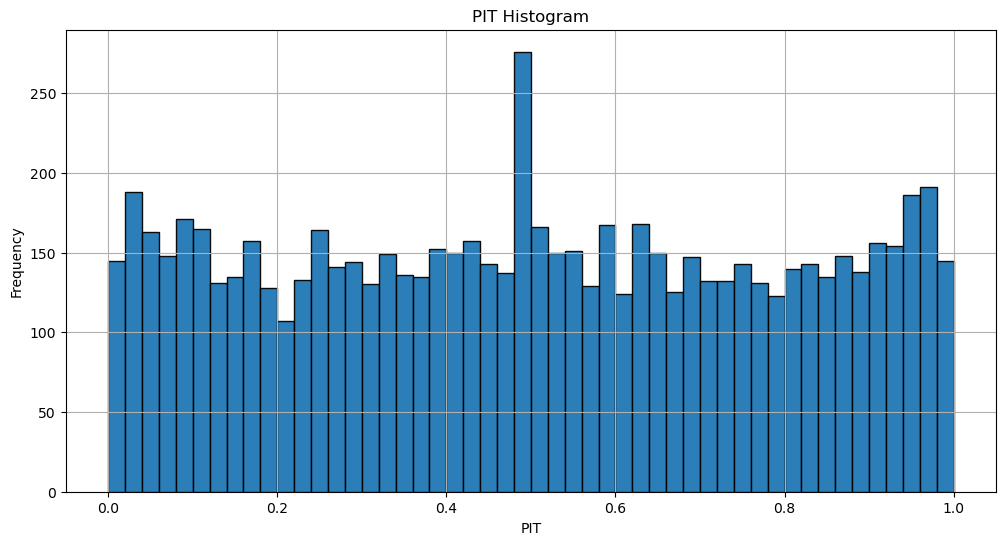

In [95]:
pit_values = smooth_cdf(r)
plt.figure(figsize=(12,6))
plt.hist(pit_values, bins=50, range=(0,1), edgecolor='k', alpha=0.95)
plt.xlabel("PIT")
plt.ylabel("Frequency")
plt.title("PIT Histogram")
plt.grid(True)
plt.show()

### KS Test

In [98]:
ks_stat, p_value = kstest(pit_values, 'uniform')
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS statistic: 0.0133, p-value: 0.1412


## Find the i, j th threshold among all thresholds (p-value > 0.05) such that Globel PIT pass KS 

In [85]:
# Search best (i, j) combination
best_result = None
best_p = -1

for i in range(len(upper_results)):
    for j in range(len(lower_results)):
        upper_best = upper_results[i]
        lower_best = lower_results[j]

        upper_threshold = upper_best['threshold']
        shape_upper = upper_best['shape']
        scale_upper = upper_best['scale']

        lower_threshold = lower_best['threshold']
        shape_lower = lower_best['shape']
        scale_lower = lower_best['scale']

        # Small transition width
        k = 0.001 * (upper_threshold - lower_threshold)

        # Fit body (t-distribution)
        df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

        # Smooth CDF using your definition
        pit_values = smooth_cdf(r)

        ks_stat, p_value = kstest(pit_values, 'uniform')

        if p_value > best_p:  # track maximum p-value
            best_p = p_value
            best_result = (i, j, ks_stat, p_value, upper_best, lower_best)

print("Best combination found:")
print(f"i={best_result[0]}, j={best_result[1]}")
print(f"KS stat={best_result[2]:.4f}, p-value={best_result[3]:.4f}")
print("Upper best:", best_result[4])
print("Lower best:", best_result[5])


Best combination found:
i=9, j=6
KS stat=0.0133, p-value=0.1412
Upper best: {'quantile': 0.9500000000000001, 'threshold': 3.716711165014107, 'n_exc': 373, 'shape': 0.0756199448047929, 'scale': 1.6505430255578153, 'ks_stat': 0.04464421528168261, 'ks_p': 0.434392225341111, 'ad_stat': 1.1087834711174764, 'score': 0.32351387822936334}
Lower best: {'quantile': 0.045000000000000005, 'threshold': -3.693496751274248, 'n_exc': 336, 'shape': 0.13436305044640257, 'scale': 1.449685421676068, 'ks_stat': 0.029845663947633105, 'ks_p': 0.9168428811934293, 'ad_stat': 0.317296076733669, 'score': 0.8851132735200624}


# EVT (POT) thresholding and GPD fit on INFY.NS

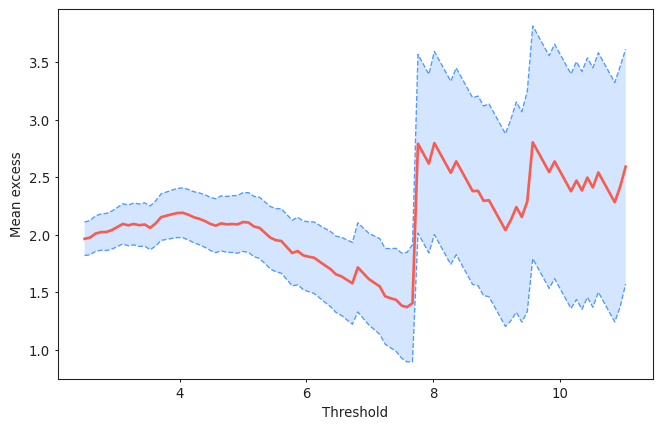

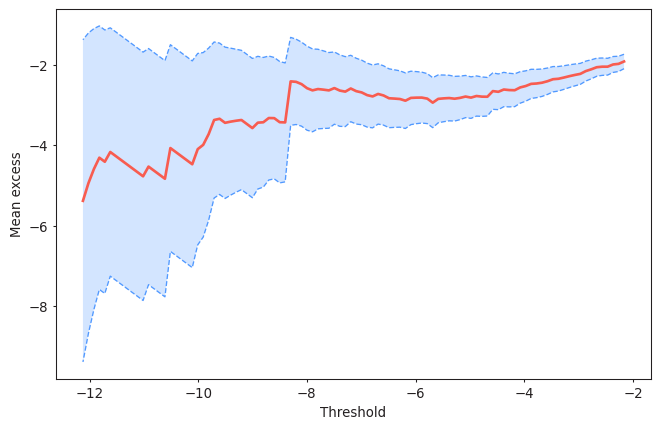

In [100]:
r = returns['INFY.NS']
model = EVA(data=r)
# Plot Mean Residual Life
plot_mean_residual_life(r, alpha=0.95, extremes_type='high')
plot_mean_residual_life(r, alpha=0.95, extremes_type='low')
plt.show()

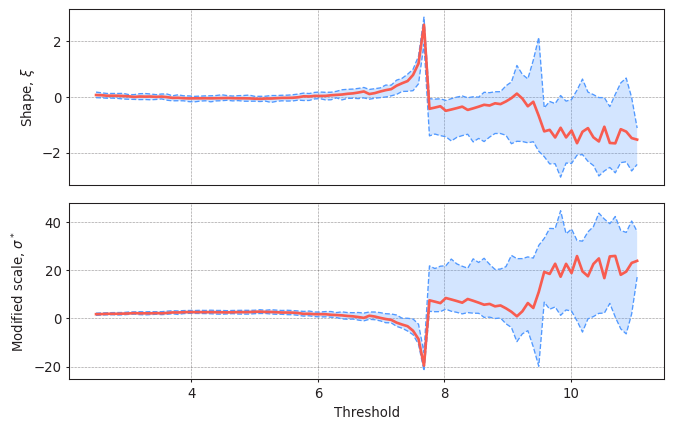

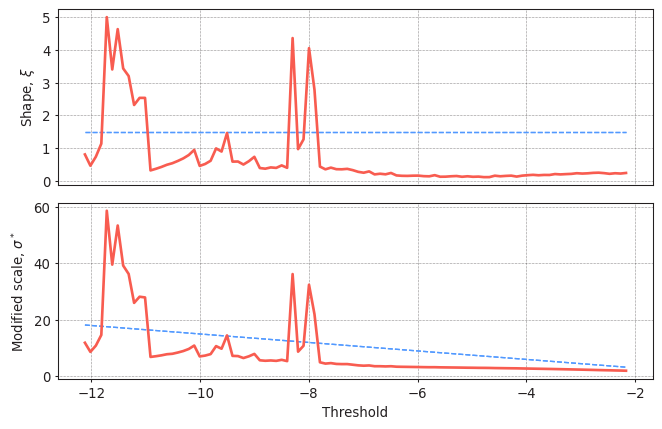

In [102]:
# Plot parameter stability
plot_parameter_stability(r, alpha=0.95, extremes_type="high")
plot_parameter_stability(r, alpha=0.95, extremes_type="low")
plt.show()

## Best Threshold Selection 
### Upper Threshold , corrosponding KS-P value, AD Statistics 

In [122]:
upper_results = select_threshold(r, q_range=np.arange(0.92, 0.981, 0.005), tail="upper")
upper_best = upper_results[1]
print("Upper Best threshold selection:")
print(f"Quantile: {upper_best['quantile']:.3f}, Threshold: {upper_best['threshold']:.4f}")
print(f"Exceedances: {upper_best['n_exc']}, Shape: {upper_best['shape']:.4f}, Scale: {upper_best['scale']:.4f}")
print(f"KS p={upper_best['ks_p']:.4f}, AD stat={upper_best['ad_stat']:.4f}, Score={upper_best['score']:.4f}")
print()


Upper Best threshold selection:
Quantile: 0.925, Threshold: 2.9710
Exceedances: 560, Shape: -0.0180, Scale: 2.1022
KS p=0.2443, AD stat=1.3934, Score=0.1050



### Lower Threshold, corrosponding KS-P value, AD Statistics

In [124]:
lower_results = select_threshold(r, q_range=np.arange(0.02, 0.081, 0.005), tail="lower")
lower_best = lower_results[3]
print("Best lower threshold selection:")
print(f"Quantile: {lower_best['quantile']:.3f}, Threshold: {lower_best['threshold']:.4f}")
print(f"Exceedances: {lower_best['n_exc']}, Shape: {lower_best['shape']:.4f}, Scale: {lower_best['scale']:.4f}")
print(f"KS p={lower_best['ks_p']:.4f}, AD stat={lower_best['ad_stat']:.4f}, Score={lower_best['score']:.4f}")


Best lower threshold selection:
Quantile: 0.055, Threshold: -3.0617
Exceedances: 411, Shape: 0.1899, Scale: 1.8274
KS p=0.6968, AD stat=0.4515, Score=0.6517


## Smooth CDF, t-Body and GPD tail with Logistics splice

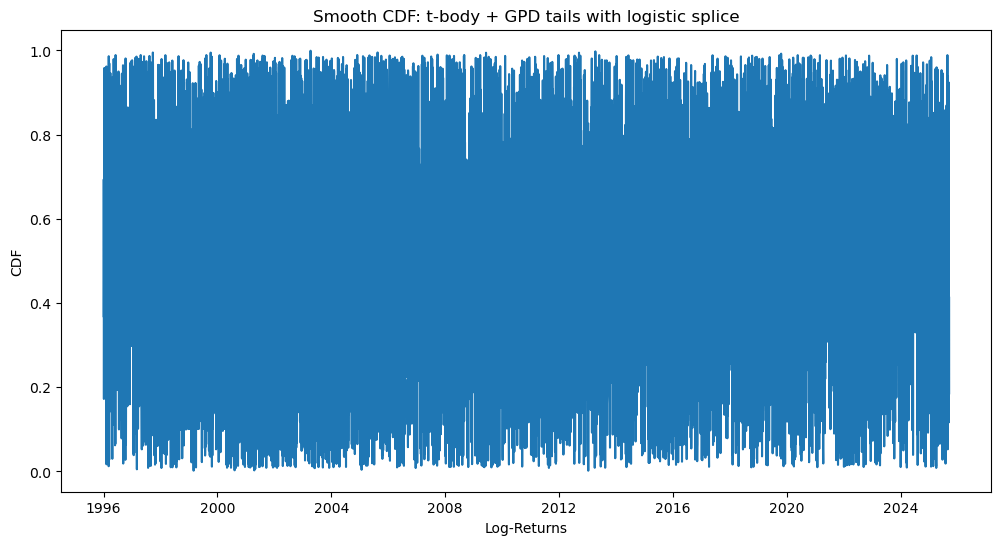

In [127]:
upper_threshold = upper_best['threshold']
shape_upper = upper_best['shape']
scale_upper = upper_best['scale']
lower_threshold = lower_best['threshold']
shape_lower = lower_best['shape']
scale_lower = lower_best['scale']

# Small transition width
k = 0.001 * (upper_threshold - lower_threshold)

# Fit body (t-distribution)
df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(r.index, smooth_cdf(r))
plt.xlabel("Log-Returns")
plt.ylabel("CDF")
plt.title("Smooth CDF: t-body + GPD tails with logistic splice")
plt.show()


### PIT  Histogram

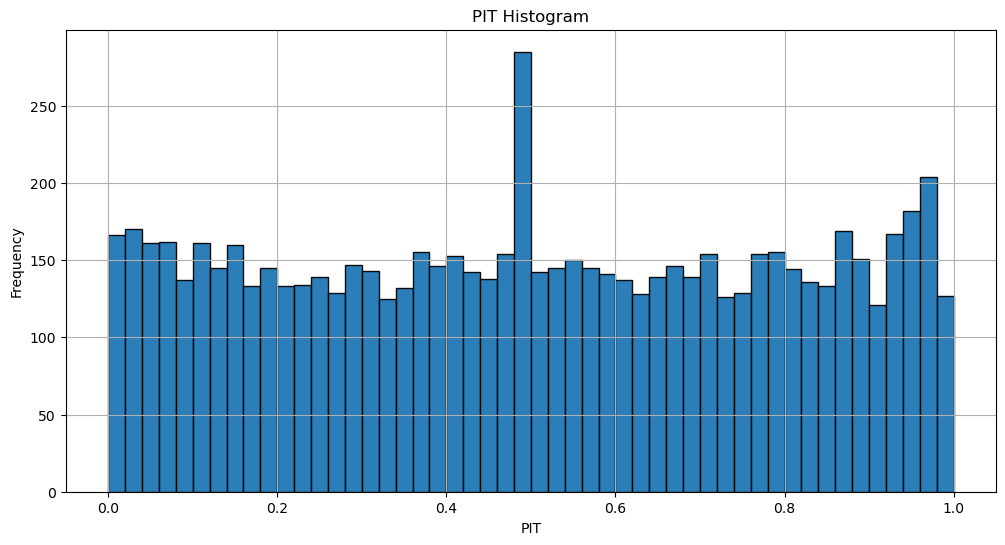

In [130]:
pit_values = smooth_cdf(r)
plt.figure(figsize=(12,6))
plt.hist(pit_values, bins=50, range=(0,1), edgecolor='k', alpha=0.95)
plt.xlabel("PIT")
plt.ylabel("Frequency")
plt.title("PIT Histogram")
plt.grid(True)
plt.show()

### KS Test

In [133]:
ks_stat, p_value = kstest(pit_values, 'uniform')

print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS statistic: 0.0116, p-value: 0.2668


## Find the i, j th threshold among all thresholds (p-value > 0.05) such that Globel PIT pass KS 

In [120]:
# Search best (i, j) combination
best_result = None
best_p = -1

for i in range(len(upper_results)):
    for j in range(len(lower_results)):
        upper_best = upper_results[i]
        lower_best = lower_results[j]

        upper_threshold = upper_best['threshold']
        shape_upper = upper_best['shape']
        scale_upper = upper_best['scale']

        lower_threshold = lower_best['threshold']
        shape_lower = lower_best['shape']
        scale_lower = lower_best['scale']

        # Small transition width
        k = 0.001 * (upper_threshold - lower_threshold)

        # Fit body (t-distribution)
        df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

        # Smooth CDF using your definition
        pit_values = smooth_cdf(r)

        ks_stat, p_value = kstest(pit_values, 'uniform')

        if p_value > best_p:  # track maximum p-value
            best_p = p_value
            best_result = (i, j, ks_stat, p_value, upper_best, lower_best)

print("Best combination found:")
print(f"i={best_result[0]}, j={best_result[1]}")
print(f"KS stat={best_result[2]:.4f}, p-value={best_result[3]:.4f}")
print("Upper best:/n", best_result[4])
print("Lower best:/n", best_result[5])


Best combination found:
i=1, j=3
KS stat=0.0116, p-value=0.2668
Upper best:/n {'quantile': 0.925, 'threshold': 2.970957767497011, 'n_exc': 560, 'shape': -0.018000667237942858, 'scale': 2.1021820432684453, 'ks_stat': 0.04301091723603079, 'ks_p': 0.24431023133372487, 'ad_stat': 1.3933665302376994, 'score': 0.10497357830995493}
Lower best:/n {'quantile': 0.05500000000000001, 'threshold': -3.0616685620374877, 'n_exc': 411, 'shape': 0.18990938095284698, 'scale': 1.827408203388678, 'ks_stat': 0.03455840829105028, 'ks_p': 0.6968232866106328, 'ad_stat': 0.45150710887594414, 'score': 0.6516725757230384}
